In [1]:
import re
import numpy as np
import random
import os
import tensorflow as tf
#from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

from numpy import loadtxt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.initializers import GlorotUniform
from keras.utils import to_categorical
from keras.models import Model


from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from matplotlib import pylab
from scipy.stats import entropy

file="amazon_cells_labelled.txt"
descripcion = {  'amazon_cells_labelled.txt': {'nombre': 'amazon', 'nclases': 2, 'fuente': "UCI", 'n_ejemplos': 1000}  }
SEED=42

def reproducible_results(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED']=str(0)
    tf.compat.v1.set_random_seed(seed)

reproducible_results(SEED)

def OpenFunc(txt):   
    val_1=[]
    val_2=[]
    with open(txt, 'r') as file_object:
        val_1 = file_object.readlines()
    for i in range (0,len(val_1)):
        val_2.append(int(val_1[i][-2]))
        val_1[i]=val_1[i].replace(val_1[i][-2:-1],' ')#.replace('.',''))
    return np.array(val_1), np.array(val_2)


def PreproFunc(text):    
    for i in range(0,len(text)):
        text[i] = text[i].lower()
        text[i] = re.sub(r'[^a-z]', ' ',text[i])
        text[i] = re.sub(r'\s+', ' ',text[i]).strip()
        #agregar lineas para stopwords
        
    return text

def FuncVocab(x):
    vocab = []
    for i in x:
        word = i.split(' ')
        vocab.extend(word)
    vocab = np.array(list(set(vocab)))
    return vocab

Text, Class = OpenFunc(file)
Text = PreproFunc(Text)

def redneuronal(n_features,mc=False ,seed=SEED):
    reproducible_results(seed)
    initializer = GlorotUniform(seed = seed)
    x_input = Input(shape=n_features)
    x = Dense(128, activation='relu', kernel_initializer=initializer, name= "Capa_1")(x_input)
    #x = Dropout(0.2,seed=SEED)(x, training=mc)
    x = Dense(64, activation='relu', kernel_initializer=initializer, name = "Capa_2")(x)
    x = Dropout(0.2,seed=SEED)(x, training=mc)
    x_out = Dense(2, activation='softmax', kernel_initializer=initializer, name = "Capa_Salida")(x)
    model = Model(inputs=x_input, outputs=x_out)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


def metricas(metrica, curva):
    todas = []
    for i in range(5):
        una = []
        for ytrue, ypred, yl in curva[i]:
            if metrica == 'acc':   
                valor = accuracy_score(ytrue, ypred)
            elif metrica == 'f1':
                valor = f1_score(ytrue, ypred)
            una.append(valor) 
        todas.append(una)
    todas = np.mean(todas, axis = 0)
    return todas


#KFold
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
clasificadores = {'MNB': MultinomialNB(), 'SVM': SVC(random_state=SEED, probability=True), 'RED': None, 'MNB_PL':MultinomialNB(), 'SVM_PL':SVC(random_state=SEED, probability=True), 'RED_PL': None}
resultados = {}

In [2]:
BATCH= 64
NCLASES = 2
T = 10
epochs = 10
batch_size = 16
for key in clasificadores:
    if key == 'MNB_PL' or key == 'SVM_PL' or key == 'RED_PL':
        CurvaType = 'PL'
    else:
        CurvaType = 'AL'
    print(key)
    
    K = 1
    Curvas = []
    Axis_X = []
    History = []
    for train_index, test_index in kf.split(Text):
        Curva_Aux = []
        Axis_Aux_X = []
        History_Aux = []
        K+=1
        #K+=1
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = Text[train_index], Text[test_index]
        y_train, y_test = Class[train_index], Class[test_index]

        #datos entrenamiento Inicial
        X_l = X_train[:BATCH]
        y_l = y_train[:BATCH]

        auxnclass=len(np.unique(y_l))

        while(auxnclass!=NCLASES):
            X_train, y_train = shuffle(X_train, y_train, random_state= SEED)
            X_l = X_train[:BATCH]
            y_l = y_train[:BATCH]
            auxnclass=len(np.unique(y_l))

        #datos no etiquetados
        X_u = X_train[BATCH:]
        y_u = y_train[BATCH:]

        Axis_Aux_X.append(len(X_l))

        vectorizer = TfidfVectorizer(vocabulary=FuncVocab(X_l))
        X_l_tfidf = vectorizer.fit_transform(X_l).toarray()
        X_test_tfidf = vectorizer.transform(X_test).toarray()

        #variable X_u tfidf
        X_u_tfidf = vectorizer.transform(X_u).toarray()
           
        
        #Fit y Predict
        if 'RED' not in key:
            clf_clasificador = clasificadores[key]
            clf_clasificador.fit( X_l_tfidf, y_l)
            predict_clf = clf_clasificador.predict(X_test_tfidf)
        else:
            if CurvaType == 'PL':  
                clf_clasificador = redneuronal(X_l_tfidf.shape[1])
            else:
                clf_clasificador = redneuronal(X_l_tfidf.shape[1], True)
            H = clf_clasificador.fit( X_l_tfidf, to_categorical(y_l, 2), verbose=0, epochs=epochs, batch_size=batch_size, validation_split=0.2)
            predict_clf = np.argmax(clf_clasificador.predict(X_test_tfidf), axis=1)
        
        
        Curva_Aux.append( [y_test, predict_clf, y_l] )
        if 'RED' in key:
            History_Aux.append([H.history['val_loss'], H.history['loss']])
        
        while(len(X_u)!=0):  
            
            if CurvaType== 'AL': 
                #if tipo de aprendizaje == activo:
                if len(X_u) >= BATCH:
                    #indexes = np.arange(BATCH) #aprendizaje aleatorio
                    #1) Predecir en Xu con predict_proba para obtener probabilidades
                    if 'RED' not in key:  
                        probs = clf_clasificador.predict_proba(X_u_tfidf)
                    else:
                        probs_Aux = []
                        for i in range(T):
                            probs_Aux.append(clf_clasificador.predict(X_u_tfidf))
                        probs_Aux = np.array(probs_Aux)
                        probs = np.mean(probs_Aux, axis = 0)
                    #2) calcular entropias}
                    entropias = []
                    for p in probs:
                        entropias.append(entropy(p, base=2))
                    entropias = np.array(entropias)
                    #3) Seleccionar los ejemplos con entropia maxima
                    indexes = np.argsort(entropias)[::-1][:BATCH]
                else:
                    indexes = np.arange(len(X_u))
            else:  
                if len(X_u) >= BATCH:
                    indexes = np.arange(BATCH)
                else:
                    indexes = np.arange(len(X_u))
                

            X_l = np.hstack((X_l,X_u[indexes]))  #index actualizado
            y_l = np.hstack((y_l,y_u[indexes]))  #index actualizado

            X_u = np.delete(X_u, indexes)  #index actualziado
            y_u = np.delete(y_u, indexes)  #index actualizado

            Axis_Aux_X.append(len(X_l))

            vectorizer = TfidfVectorizer(vocabulary=FuncVocab(X_l))
            X_l_tfidf = vectorizer.fit_transform(X_l).toarray()
            X_test_tfidf = vectorizer.transform(X_test).toarray()

            
            
            #variable X_u tfidf
            if len(X_u) > 0:
                X_u_tfidf = vectorizer.transform(X_u).toarray()
                
                
            ##Fit y Predict
            if 'RED' not in key:
                clf_clasificador = clasificadores[key]
                clf_clasificador.fit( X_l_tfidf, y_l)
                predict_clf = clf_clasificador.predict(X_test_tfidf)
            else:
                if CurvaType == 'PL':
                    clf_clasificador = redneuronal(X_l_tfidf.shape[1])
                else:
                    clf_clasificador = redneuronal(X_l_tfidf.shape[1], True)
                H = clf_clasificador.fit( X_l_tfidf, to_categorical(y_l, 2), verbose=0, epochs=epochs, batch_size=batch_size, validation_split=0.2)
                predict_clf = np.argmax(clf_clasificador.predict(X_test_tfidf), axis=1)
            
            
            Curva_Aux.append( [y_test, predict_clf, y_l] )
            if 'RED' in key:
                History_Aux.append([H.history['val_loss'], H.history['loss']]) 
                
        if 'RED' in key:   
            History.append(History_Aux)
        Curvas.append(Curva_Aux)
        Axis_X.append(Axis_Aux_X)
    #resultados[key] = np.array(Curvas).mean(axis=0)
    resultados[key] = np.array(Curvas)
    if 'RED' in key:
        resultados[key+'_History'] = np.array(History).mean(axis=0)
resultados['Axis_X'] = np.array(Axis_X).mean(axis=0).astype(int)

MNB


C:\Users\Pc Gamer\AppData\Local\Temp\ipykernel_15304\1815972417.py:146: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  resultados[key] = np.array(Curvas)


SVM


C:\Users\Pc Gamer\AppData\Local\Temp\ipykernel_15304\1815972417.py:146: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  resultados[key] = np.array(Curvas)


RED
7/7 [==============================] - 0s 2ms/step
MNB_PL


C:\Users\Pc Gamer\AppData\Local\Temp\ipykernel_15304\1815972417.py:146: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  resultados[key] = np.array(Curvas)


SVM_PL


C:\Users\Pc Gamer\AppData\Local\Temp\ipykernel_15304\1815972417.py:146: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  resultados[key] = np.array(Curvas)


RED_PL
7/7 [==============================] - 0s 2ms/step


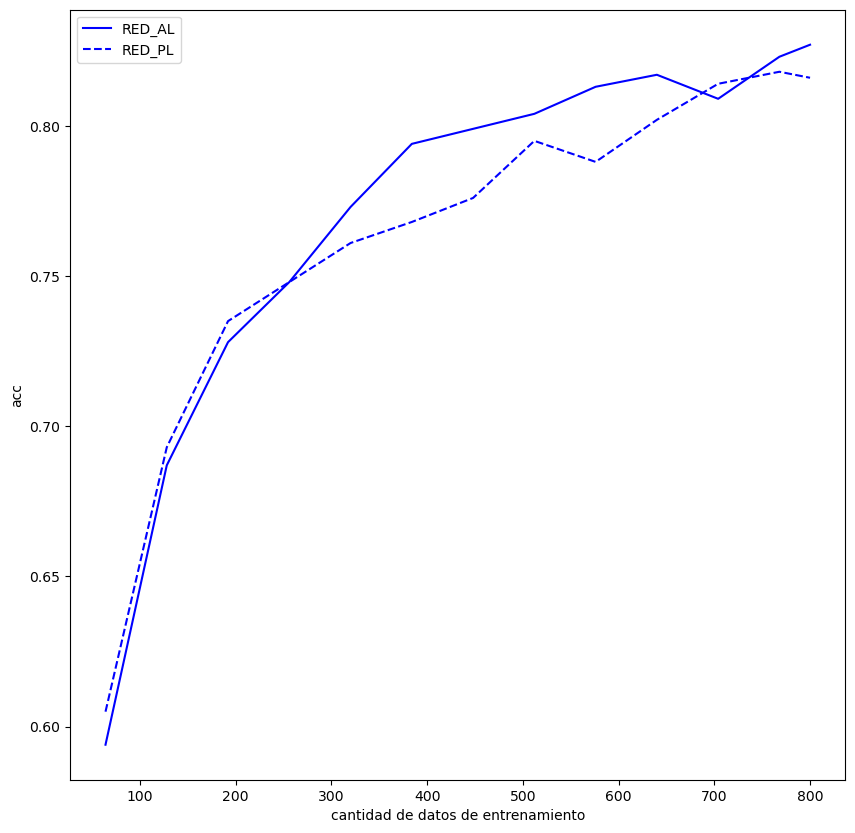

In [3]:
metrica = 'acc'
fig = pylab.figure(1,figsize=(10,10))



pylab.plot(resultados['Axis_X'], metricas(metrica, resultados['MNB']), 'r', label = 'Naive Bayes_AL')
pylab.plot(resultados['Axis_X'], metricas(metrica, resultados['SVM']), 'g', label = 'SVM_AL')
pylab.plot(resultados['Axis_X'], metricas(metrica, resultados['RED']), 'b', label = 'RED_AL') #label = 'RED-'+tipo
pylab.plot(resultados['Axis_X'], metricas(metrica, resultados['MNB_PL']), 'r--', label = 'Naive Bayes_PL')
pylab.plot(resultados['Axis_X'], metricas(metrica, resultados['SVM_PL']), 'g--', label = 'SVM_PL')
pylab.plot(resultados['Axis_X'], metricas(metrica, resultados['RED_PL']), 'b--', label = 'RED_PL')

pylab.xlabel("cantidad de datos de entrenamiento")
pylab.ylabel(metrica)
pylab.legend()


pylab.show()

In [16]:
hiper_parametros = {'SVM':clasificadores['SVM'].get_params(),
                   'MNB': clasificadores['MNB'].get_params(),
                   'RED': {'capas_ocultas': 2, 'epocas': epochs, 'batch': BATCH, 'funciones_acti': "relu y softmax", 'optimizador': "adam"}}

import pickle
diccionario= {'resultados':resultados,
             'descripcion':descripcion,
             'hiperparametros':hiper_parametros}


with open('resultados_curvas.pkl','wb') as a:
    pickle.dump(diccionario, a, protocol=2)

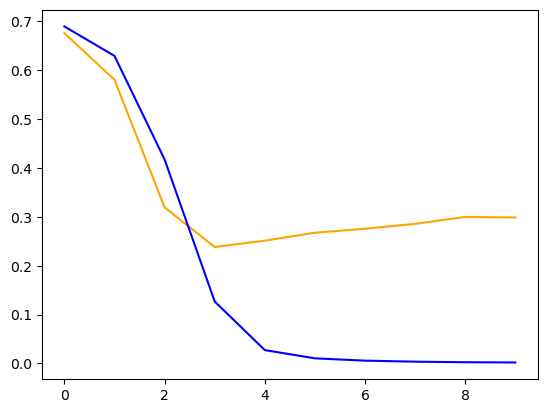

In [11]:
fig = pylab.figure()
pylab.plot(val_loss, 'orange')
pylab.plot(train_loss, 'blue')
